In [196]:
import pandas as pd
import numpy as np

import re
import random

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import nltk
from pattern.en import lemma

## Load and Clean Data

In [19]:
df = pd.read_csv('data/train.csv')
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [20]:
# replace %20 with '' in keyword. used in place of space [] character
df['keyword'] = df['keyword'].apply(lambda s: s.replace('%20', '') if isinstance(s, str) else s)

#### What fraction of keywords and location are missing?

Only 61 rows have keywords missing. We want to see if there is any preliminary difference we can spot between tweets that are identified as disaster vs those that are not.

On the other hand, nearly 33% (or 2533) tweets have location tag missing. This does not vary between disaster vs non-disaster tweets.

In [21]:
print(df.keyword.isna().sum()) #keywords missing
print(df.location.isna().sum()) #location missing

df.groupby('target')['location'].apply(lambda x: x.isna().sum()/len(x))

61
2533


target
0    0.335790
1    0.328646
Name: location, dtype: float64

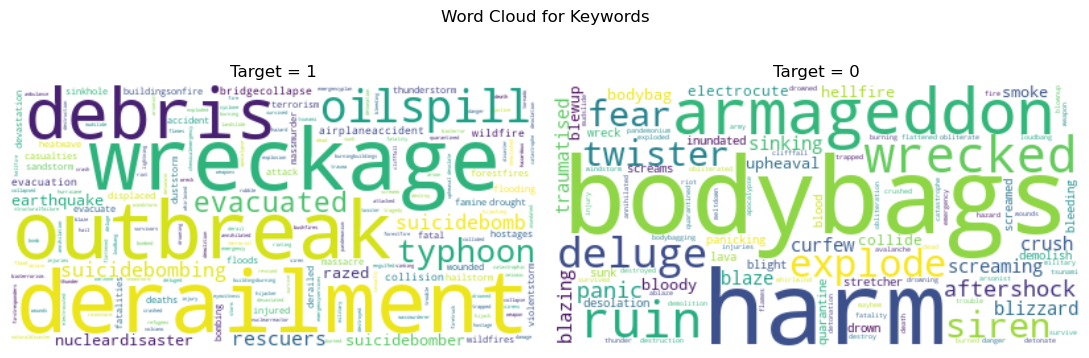

In [22]:
stopwords = set(STOPWORDS)

dict_disaster = df.query('target == 1')['keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Keywords")
plt.tight_layout();
plt.show();

### Cleaning Data - URL, Punctuations, Emoji, etc

In [59]:
def clean_tweet(tweet):

    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    tweet = reg_punc.sub(r'', tweet)

    # remove html
    reg_html = re.compile(r'<.*?>')
    tweet = reg_html.sub(r'', tweet)

    # remove url
    reg_url = re.compile(r'http\S+')
    tweet = reg_url.sub(r'', tweet)

    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    tweet = reg_num.sub(r'', tweet)

    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    tweet = reg_spcl.sub(r'', tweet)

    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = emoji_url.sub(r'', tweet)

    return tweet

df['clean_text'] = df['text'].apply(lambda x: clean_tweet(x))

#### Lemmatization

In [108]:
def lemmatize(tweet):
    lemmatized_tweet = " ".join([word if word.lower()=="this" else lemma(word) for word in tweet.split()])
    return lemmatized_tweet

df['lemmatized_text'] = df['clean_text'].apply(lambda x: lemmatize(x))

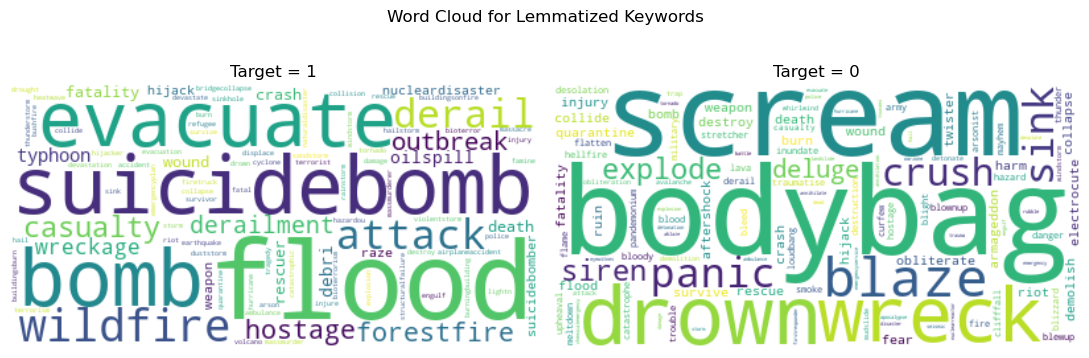

In [61]:
df['lemmatized_keyword'] = df['keyword'].apply(lambda x: lemmatize(x) if isinstance(x,str) else x)

dict_disaster = df.query('target == 1')['lemmatized_keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['lemmatized_keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Lemmatized Keywords")
plt.tight_layout();
plt.show();

## Build Models

#### Logistic Regression using Keywords
In the statistical inference portion of the code, we observed that there is some difference between the keywords of tweets that represented disaster vs the ones that didn't. Based on this assumption, we can build a simple logistic regression classifier that uses the keywords of the tweets.

**Advantages**
1. Very easy to implement and understand - the coefficients give us a clear intuition of which words increase the probability of the tweet being about an actual disaster vs not.

**Disadvantages**
1. Limited vocabulary. If there is a keyword in the test/validation dataset that we didnt encounter in the training dataset, the model would not know how to handle it.
2. We are not using any of the information in the actual text of the tweets.
3. In any real world application, we would probably have a dataset comprising just the tweet without any keyword attached to it. Limits the application of this model.

             LR_coef
wreckage    2.627808
derailment  2.627808
debri       2.587786
outbreak    2.381983
typhoon     2.339643
...              ...
blaze      -2.069669
panic      -2.170459
ruin       -2.317637
bodybag    -2.346364
aftershock -2.523712

[177 rows x 1 columns]


0         1
precision  0.757402  0.704230
recall     0.792968  0.659957

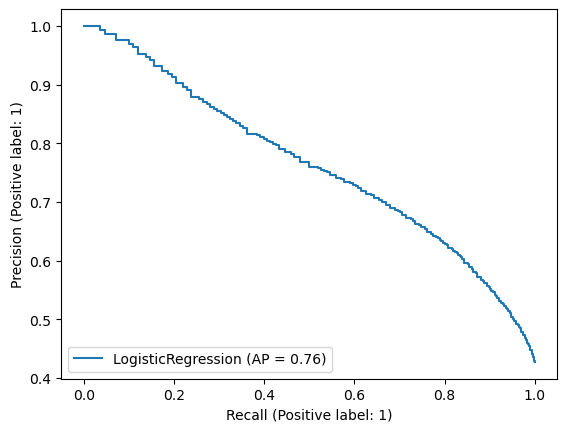

In [226]:
count_vec = CountVectorizer()
X_keyword = count_vec.fit_transform(df['lemmatized_keyword'].dropna())
y_keyword = df.dropna(subset= ['lemmatized_keyword'])['target']

keyword_lreg = LogisticRegression(fit_intercept= False)
keyword_lreg.fit(X_keyword,y_keyword)

print(pd.DataFrame(keyword_lreg.coef_, columns= count_vec.get_feature_names_out(), index= ["LR_coef"])
      .T.sort_values("LR_coef", ascending= False) )

PrecisionRecallDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
# ConfusionMatrixDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
pd.DataFrame(precision_recall_fscore_support(y_keyword, keyword_lreg.predict(X_keyword)), index= ['precision','recall','f1score','support']).head(2)

#### TF-IDF Vectorization

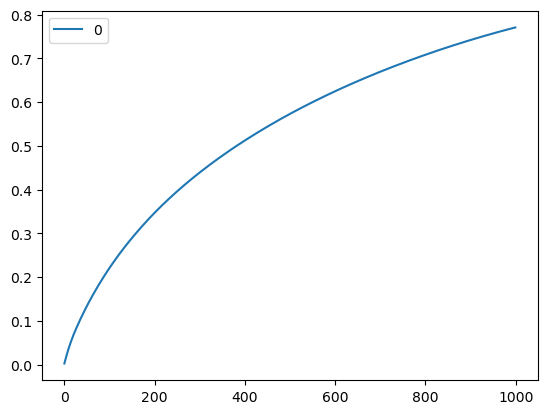

['aa' 'aba' 'aba woman' ... 'zombie apocalypse' 'zone' 'zouma']
(7613, 4849)


In [227]:
corpus = df['lemmatized_text'].tolist()

vectorizer = TfidfVectorizer(ngram_range= (1,3), stop_words= 'english', strip_accents= 'ascii', min_df= 5e-4)
X = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components= 1000)
X_pca = svd.fit_transform(X)

pd.DataFrame(svd.explained_variance_ratio_).cumsum().plot()
plt.show()

print(vectorizer.get_feature_names_out())
print(X.shape)

In [ ]:
y_train = df['target']
logreg_model = LogisticRegression(fit_intercept= False)
logreg_model.fit(X_pca, y_train)

knn_model = KNeighborsClassifier(n_neighbors= 10)
knn_model.fit(X_pca, y_train);

tree_model = DecisionTreeClassifier(min_samples_leaf= 2)
tree_model.fit(X_pca, y_train);

C:\Users\garim\anaconda3\envs\github\Lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


0         1
precision  0.968855  0.994286
recall     0.995854  0.957505

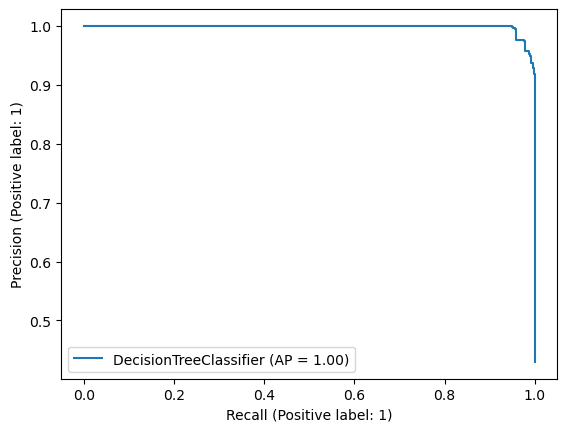

In [186]:
model_slct = tree_model

PrecisionRecallDisplay.from_estimator(model_slct, X_pca, y_train)
ConfusionMatrixDisplay.from_estimator(model_slct, X_pca, y_train)
pd.DataFrame(precision_recall_fscore_support(y_train, model_slct.predict(X_pca)), index= ['precision','recall','f1score','support']).head(2)

In [188]:
idx_random = random.sample(df.index.tolist(), 10)
df_random = df.loc[idx_random, ['keyword','text','lemmatized_text','target']]
df_random['predict'] = model_slct.predict(X_pca[idx_random, :])

df_random

keyword                                               text  \
3756         fire  Fire Meet Gasoline always gotta get played twi...   
5619     refugees  Newlyweds feed Syrian refugees at their weddin...   
4699    landslide  being stuck on a sleeper train for 24 hours af...   
6904  traumatised  I'm slightly traumatised after this week's one...   
3477    explosion  GAElite 0    Explosion Greg 2 [Top 3rd] [0 Out...   
87       accident  RT nAAYf: First accident in years. Turning ont...   
5653       rescue  Rescue of the day: ItÛªs World Cat Day Saturd...   
1083         bomb    @SwellyJetEvo Disneyland! Tacos there are bomb!   
6875  traumatised  Traumatised after seeing a baby literally fall...   
2192       debris  Debris confirmed from MH370; relatives hope fo...   

                                        lemmatized_text  target  predict  
3756  fire meet gasoline alway gotta get play twice lol       0        0  
5619  newlywed feed syrian refugee at their wed cbc ...       0        0  
4699  be stick on a sleeper train for hour after der...       1        1  
6904    im slightly traumatise after this week one born       0        0  
3477  gaelite explosion greg top rd out ball strike ...       1        1  
87    rt naayf first accident in year turn onto chan...       1        1  
5653  rescue of the day itûª world cat day saturday ...       0        0  
1083         swellyjetevo disneyland taco there be bomb       1        1  
6875  traumatise after see a baby literally fall out...       0        0  
2192  debri confirm from mh relative hope for discov...       1        1

In [189]:
## check a new random tweet
test_tweets = ["This is a test tweet",
              "This is a test tweet. See if word fatal effects it"]

df_test = pd.read_csv("data/test.csv")
test_tweets = df_test['text'].tolist()
res = pd.DataFrame(test_tweets, columns = ['text'])

test_tweets = [lemmatize(clean_tweet(tt)) for tt in test_tweets]
X_test = svd.transform(vectorizer.transform(test_tweets))
y_test = model_slct.predict(X_test)
res['target'] = y_test


print(res.loc[random.sample(res.index.tolist(),20)])

                                                   text  target
2596  http://t.co/OK9EBHurfl If your neighborhood sc...       1
2930  Loving you was like throwing a lasso around a ...       1
1020  @who_mikejoness I hate seeing the boy get fuck...       1
820   omg I have a huge crush on her because of her ...       0
2794  @amyschumer you eat food in order to survive?!...       1
1703  I hope the rain stops the forest fires tbh we'...       1
2577  A subcontractor working for French seismic sur...       1
660   Alaska's #Wolves face catastrophe Alexander #A...       0
2215  #interracial #sex #porn http://t.co/Kjh99CzHFe...       0
1069  Latest : Suresh Prabhu calls Harda derailment ...       1
2734  reaad/ plsss Pic of 16yr old PKK suicide bombe...       1
2273  Families to sue over Legionnaires: More than 4...       1
1730  We The Free Hailstorm Maxi http://t.co/Cnn1nXXNwc       1
1086  And the 10 horns which u saw on the beast thes...       0
2945  Rly tragedy in MP: Some live to re

In [192]:
res.loc[2596,"text"]

'http://t.co/OK9EBHurfl If your neighborhood school falls into a sinkhole State Sen. Steve Yarbrough may be close by...'

In [159]:
df_submission = df_test[['id']]
df_submission['target'] = y_test
df_submission.to_csv("data/submission_1.csv", index= False)

df_submission

C:\Users\garim\AppData\Local\Temp\ipykernel_30412\4274932975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['target'] = y_test


id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]

In [161]:
for ii in random.sample(df_test.index.tolist(), 20):
    print(df_test.loc[ii,"text"])
    print("Keyword: " + str(df_test.loc[ii,"keyword"]))
    print("Target: " + str(y_test[ii]))
    print("-----------------------------------------------------------------")

You still acting like you were the one wounded. Didn't you do the stabbing?...
Keyword: wounded
Target: 0
-----------------------------------------------------------------
RT @australian Debris found on an Indian Ocean island confirmed to be from flight #MH370. http://t.co/gY9MrSl6x2
Keyword: wreckage
Target: 1
-----------------------------------------------------------------
The midnight song I cry out goes 'In reality I... in reality I... was very lonely'
Even if it is erased by the blazing sun
Keyword: blazing
Target: 0
-----------------------------------------------------------------
AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/7X3PDDbT0Z
Keyword: ambulance
Target: 0
-----------------------------------------------------------------
Myanmar Flood Victims Need More Relief Aid and Food: Regions struggle with flood aftermath and dwindling suppl... http://t.co/O5adXdNnII
Keyword: flood
Target: 1
--------------------------------------------